In [1]:
!nvidia-smi

Fri Aug 23 00:47:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        On  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8               1W /  50W |      6MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Installing Packages

In [2]:
!pip uninstall gdown -y && pip install gdown
!pip install einops transformers

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)


# Some boilerplate code and imports need to for running the rest of the notebook

In [3]:
import copy
import os
import random

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.fft
from torch import nn, einsum
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from torch.utils.data import DataLoader, Subset
from torchaudio.datasets import SPEECHCOMMANDS
from transformers.models.wav2vec2.modeling_wav2vec2 import _compute_mask_indices
from tqdm.notebook import tqdm

In [4]:
class PreNorm(nn.Module):
    """
    Pre layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PreNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PreNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return:
        """
        return self.fn(self.norm(x), **kwargs)


class PostNorm(nn.Module):
    """
    Post layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PostNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PostNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return: PostNorm output
        """
        return self.norm(self.fn(x, **kwargs))


class FeedForward(nn.Module):
    """
    Feed forward model
    """
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Initialises FeedForward module
        :param dim: feedforward dim
        :param hidden_dim: hidden dimension of feedforward layer
        :param dropout: feedforward dropout percentage
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Forward method for feedforward module
        :param x: input tensor
        :return: FeedForward output
        """
        return self.net(x)


class Attention(nn.Module):
    """
    Attention module
    """
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        """
        Initialises Attention module
        :param dim: transformer dimension
        :param heads: number of attention heads
        :param dim_head: attention head dimension
        :param dropout: attention output dropout
        """
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        Forward method for Attention module
        :param x: input tensor
        :return: Attention module output
        """
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    """
    Transformer model
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, pre_norm=True, dropout=0.):
        """
        Initialises Transformer model
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads for each transformer layer
        :param dim_head: dimension of each attention head
        :param mlp_dim: MLP dimension
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param dropout: dropout percentage of Attention of FeedForward modules
        """
        super().__init__()
        self.layers = nn.ModuleList([])

        P_Norm = PreNorm if pre_norm else PostNorm

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                P_Norm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                P_Norm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        """
        Forward method for Transformer model
        :param x: input tensor
        :return: Tuple of model output, hidden states of transformer and attentions from each transformer layer
        """
        hidden_states = []
        attentions = []
        for attn, ff in self.layers:
            x = attn(x) + x
            attentions.append(x)
            x = ff(x) + x
            hidden_states.append(x)
        return x, hidden_states, attentions


class KWT(nn.Module):
    """
    KWT model
    """
    def __init__(self, input_res, patch_res, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1,
                 dim_head=64, dropout=0., emb_dropout=0., pre_norm=True, **kwargs):
        """
        Initialises KWT model
        :param input_res: input spectrogram size
        :param patch_res: patch size
        :param num_classes: number of keyword classes
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads
        :param mlp_dim: MLP dimension
        :param pool: specifies whether CLS token or average pooling of transformer model is used for classification
        :param channels: Number of input channels
        :param dim_head: dimension of attention heads
        :param dropout: dropout of transformer attention and feed forward layers
        :param emb_dropout: dropout of embeddings
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param kwargs: Keyword arguments
        """
        super().__init__()

        num_patches = int(input_res[0] / patch_res[0] * input_res[1] / patch_res[1])

        patch_dim = channels * patch_res[0] * patch_res[1]
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_res[0], p2=patch_res[1]),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.mask_embedding = nn.Parameter(torch.FloatTensor(dim).uniform_())
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, pre_norm, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        # Create classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x, mask=None, output_hidden_states=False, output_attentions=False):
        """
        Forward method of KWT model
        :param x: input tensor
        :param mask: input mask
        :param output_hidden_states: specifies whether hidden states are output
        :param output_attentions: specifies whether attentions are output
        :return: KWT model output, if output_hidden_states and/or output_attentions the classification head is skipped
        """
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        # Add cls token embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)

        # Mask input
        if mask is not None:
            x[mask] = self.mask_embedding

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, hidden_states, attentions = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        if any([output_hidden_states, output_attentions]):
            outputs = (self.mlp_head(x), hidden_states) if output_hidden_states else (self.mlp_head(x), )
            outputs = outputs + (attentions, ) if output_attentions else outputs
            return outputs
        return self.mlp_head(x)



class EMA:
    """
    Modified version of class fairseq.models.ema.EMA.
    """

    def __init__(self, model: nn.Module, device=None, skip_keys=None, ema_decay=0.999):
        self.model = copy.deepcopy(model)
        self.model.requires_grad_(False)
        if device is not None:
            self.model.to(device)
        self.device = device
        self.skip_keys = skip_keys or set()
        self.decay = ema_decay
        self.num_updates = 0

    def step(self, new_model: nn.Module):
        ema_state_dict = {}
        ema_params = self.model.state_dict()
        for key, param in new_model.state_dict().items():
            ema_param = ema_params[key].float()
            if key in self.skip_keys:
                ema_param = param.to(dtype=ema_param.dtype).clone()
            else:
                ema_param.mul_(self.decay)
                ema_param.add_(param.to(dtype=ema_param.dtype), alpha=1 - self.decay)
            ema_state_dict[key] = ema_param
        self.model.load_state_dict(ema_state_dict, strict=False)
        self.num_updates += 1

    def restore(self, model: nn.Module):
        d = self.model.state_dict()
        model.load_state_dict(d, strict=False)
        return model

    def _set_decay(self, decay):
        self.decay = decay

    def get_decay(self):
        return self.decay

    @staticmethod
    def get_annealed_rate(start, end, curr_step, total_steps):
        r = end - start
        pct_remaining = 1 - curr_step / total_steps
        return end - r * pct_remaining


class AudioMaskingGenerator:
    def __init__(self,
                 mask_prob: float,
                 mask_length: int,
                 attention_mask=None,
                 min_masks: int = 0):
        self.mask_prob = mask_prob
        self.mask_length = mask_length
        self.attention_mask = attention_mask
        self.min_masks = min_masks

    def __call__(self, shape):
        batch_size, audio_size = shape
        mask = _compute_mask_indices((batch_size, audio_size),
                                     self.mask_prob,
                                     self.mask_length,
                                     self.attention_mask,
                                     self.min_masks)
        mask = torch.from_numpy(mask)
        return mask


class Data2Vec(nn.Module):
    """
    Data2Vec main module.
    """

    def __init__(self,
                 encoder: nn.Module,
                 model_embed_dim: int,
                 ema_decay: float,
                 ema_end_decay: float,
                 ema_anneal_end_step: int,
                 average_top_k_layers: int,
                 normalize_targets: bool,
                 **kwargs):
        """
        :param encoder: transformer encoder
        :param model_embed_dim: Embedding dimension of transformer encoder
        :param ema_decay: EMA model decay
        :param ema_end_decay: EMA model end decay
        :param ema_anneal_end_step: Number of annealing steps for EMA model decay
        :param average_top_k_layers: Number of encoder layers to use for Data2Vec target
        :param normalize_targets: Specifies whether Dat2Vec targets are normalized
        :param kwargs: keyword arguments
        """
        super(Data2Vec, self).__init__()
        self.encoder = encoder
        self.embed_dim = model_embed_dim
        self.ema_decay = ema_decay
        self.ema_end_decay = ema_end_decay
        self.ema_anneal_end_step = ema_anneal_end_step
        self.average_top_k_layers = average_top_k_layers
        self.normalize_targets = normalize_targets
        self.__dict__.update(kwargs)

        self.ema = EMA(self.encoder, device="cuda")  # Instantiate teacher encoder as EMA of student encoder
        self.regression_head = self._build_regression_head()  # Instantiate regression head to predict target

    def _build_regression_head(self):
        return nn.Linear(self.embed_dim, self.embed_dim)

    def ema_step(self):
        """
        Function which to step the EMA encoder
        """
        if self.ema_decay != self.ema_end_decay:
            if self.ema.num_updates >= self.ema_anneal_end_step:
                decay = self.ema_end_decay
            else:
                decay = self.ema.get_annealed_rate(
                    self.ema_decay,
                    self.ema_end_decay,
                    self.ema.num_updates,
                    self.ema_anneal_end_step,
                )
            self.ema.decay = decay
        if self.ema.decay < 1:
            self.ema.step(self.encoder)

    def forward(self, student_input, teacher_input=None, mask=None):
        """
        Data2Vec forward method.
        :param student_input: Input for student encoder
        :param teacher_input: Input for teacher encoder
        :param mask: mask for student input if input is not already masked
        :return: Data2Vec model output x, y for student prediction and teacher target, respectively
        """

        encoder_out, student_hidden_states = self.encoder(student_input, mask=mask, output_hidden_states=True)
        if teacher_input is None:
            return encoder_out
        x = student_hidden_states[-1]
        with torch.no_grad():
            self.ema.model.eval()

            _, teacher_hidden_states = self.ema.model(teacher_input, mask=None, output_hidden_states=True)

            y = teacher_hidden_states[-self.average_top_k_layers:]
            y = [F.instance_norm(tl.float().transpose(1, 2)).transpose(1, 2) for tl in y]
            y = sum(y) / len(y)
            if self.normalize_targets:
                y = F.instance_norm(y).transpose(1, 2).transpose(1, 2)

        x = x[mask]
        y = y[mask]

        x = self.regression_head(x)

        return x, y


class SpeechCommands(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


class WarmUpLR(torch.optim.lr_scheduler._LRScheduler):
    """WarmUp learning rate scheduler.

    Args:
        optimizer (optim.Optimizer): Optimizer instance
        total_iters (int): steps_per_epoch * n_warmup_epochs
        last_epoch (int): Final epoch. Defaults to -1.
    """

    def __init__(self, optimizer: torch.optim.Optimizer, total_iters: int, last_epoch: int = -1):
        """Initializer for WarmUpLR"""

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """Learning rate will be set to base_lr * last_epoch / total_iters."""

        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]


def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


labels_list = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
          'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine',
          'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
          'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels_list.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels_list[index]


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


def spec_augment(mel_spec, n_time_masks=2, time_mask_width=25, n_freq_masks=2, freq_mask_width=7):
    for i in range(mel_spec.size(0)):
      offset, begin = 0, 0
      for _ in range(n_time_masks):
          offset = random.randint(0, time_mask_width)
          begin = random.randint(0, mel_spec.size(3) - offset)
          mel_spec[i, :, :, begin: begin + offset] = 0.0

      for _ in range(n_freq_masks):
          offset = random.randint(0, freq_mask_width)
          begin = random.randint(0, mel_spec.size(2) - offset)
          mel_spec[i, : ,begin: begin + offset, :] = 0.0

    return mel_spec


def plot_loss_accuracy(losses, accuracies,
                       validation_losses=None,
                       validation_accuracies=None,
                       grid=False):
  fig, axs = plt.subplots(2, 1, sharex=True)
  epochs_list = list(losses.keys())
  epochs_list = [int(number) for number in epochs_list]
  losses_list = list(losses.values())
  accuracies_list = list(accuracies.values())
  axs[0].plot(epochs_list, losses_list, label="train")
  axs[1].plot(epochs_list, accuracies_list, label="train")
  if (validation_losses and validation_accuracies):
    validation_epochs_list = list(validation_losses.keys())
    validation_epochs_list = [int(number) for number in validation_epochs_list]
    validation_losses_list = list(validation_losses.values())
    validation_accuracies_list = list(validation_accuracies.values())
    axs[0].plot(validation_epochs_list, validation_losses_list, label="validation")
    axs[1].plot(validation_epochs_list, validation_accuracies_list, label="validation")
    axs[0].legend()
    axs[1].legend()

  axs[0].set_ylabel("Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_ylim(0.0, 1.0)

  if grid:
    axs[0].grid()
    axs[1].grid()

  plt.show()


def plot_loss_and_variance(losses, target_vars, prediction_vars, grid=False):
  fig, axs = plt.subplots(2, 1, sharex=True)

  epochs_list = list(losses.keys())
  epochs_list = [int(number) for number in epochs_list]
  losses_list = list(losses.values())
  target_vars_list = list(target_vars.values())
  prediction_vars_list = list(prediction_vars.values())
  axs[0].plot(epochs_list, losses_list)
  axs[1].plot(epochs_list, target_vars_list, label="Target")
  axs[1].plot(epochs_list, prediction_vars_list, label="Prediction")

  axs[0].set_ylabel("Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Variance")

  axs[0].ticklabel_format(style="sci", scilimits=(0, 0))

  if grid:
    axs[0].grid()
    axs[1].grid()

  plt.show()



def compute_var(y: torch.Tensor):
    y = y.view(-1, y.size(-1))
    return torch.sqrt(y.var(dim=0) + 1e-6).mean()


def load_pretrained_checkpoint(model):
  import subprocess as sp
  if not os.path.exists("pretrained_encoder.pth"):
    print("Downloading checkpoint...")
    sp.call("gdown 1djqZQX4wpZ9dJgkzVbi_UAOAO59G-pcv", shell=True)
  else:
    print("Checkpoint already available skipping download...")

  print("Loading checkpoint weights...")
  ckpt = torch.load("./pretrained_encoder.pth", map_location=torch.device('cpu'))
  model.load_state_dict(ckpt["model_state_dict"])
  print("Checkpoint loaded.")

  return model


def seed_everything(seed: int) -> None:
    """
    Set manual seed of python, numpy, pytorch and cuda
    :param seed: Supplied seed.
    :return: None
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print(f'Set {seed=}')

checking if gpu is available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setting random seed for reproducibility(randomness)
1. randomly shuffling data
2. randomly initializing model weights
3. splitting data into training and testing sets.

In [6]:
seed = 0
seed_everything(seed)

Set seed=0


## Dataset

Testing if Data2Vec can improve KWS performance in label-deficient settings.

In [7]:
original_train_set = SpeechCommands("training")
validation_set = SpeechCommands("validation")
test_set = SpeechCommands("testing")

examples_original_train = len(original_train_set)

pretrain_percentage = 0.8 # You can change this to make the labelled training set smaller

indices = np.arange(examples_original_train)
pretrain_indices = np.random.choice(indices, round(len(original_train_set)*pretrain_percentage), replace=False)
train_indices = indices[~np.isin(indices, pretrain_indices)]

pretrain_set = Subset(original_train_set,
                      indices=pretrain_indices)
reduced_train_set = Subset(original_train_set,
                           indices=train_indices)

print(f"Examples in pretrain: {len(pretrain_set)}, Examples in train: {len(reduced_train_set)}, Examples in validation: {len(validation_set)}, Examples in test: {len(test_set)}")

Examples in pretrain: 67874, Examples in train: 16969, Examples in validation: 9981, Examples in test: 11005


# Feature Extracting

Need a method for extracting speech features. MFCCs(Mel Frequency Cepstral Components) has been used with some common parameters

In [8]:
from torchaudio.transforms import MFCC

# Settings for MelSpectrogram computation
melkwargs = {"n_mels": 80, # How many mel frequency filters are used
             "n_fft": 480, # How many fft components are used for each feature
             "win_length": 480, # How many frames are included in each window
             "hop_length": 160, # How many frames the window is shifted for each component
             "center": False, # Whether frams are padded such that the component of timestep t is centered at t
             "f_max": 7600, # Maximum frequency to consider
             "f_min": 20}

# Instantiate MFCC feature extractor
mfcc = MFCC(n_mfcc=40, # Number of cepstrum components
            sample_rate=16000, # Sample rate of input audio
            melkwargs=melkwargs) # Keyword arguments for MelSpectogram

waveform:  tensor([[ 0.0000e+00, -9.1553e-05, -3.0518e-05,  ...,  3.0518e-05,
         -1.2207e-04, -2.1362e-04]])
Type,  <class 'torch.Tensor'> torch.Size([1, 16000])


/tmp/ipykernel_4561/2316008788.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


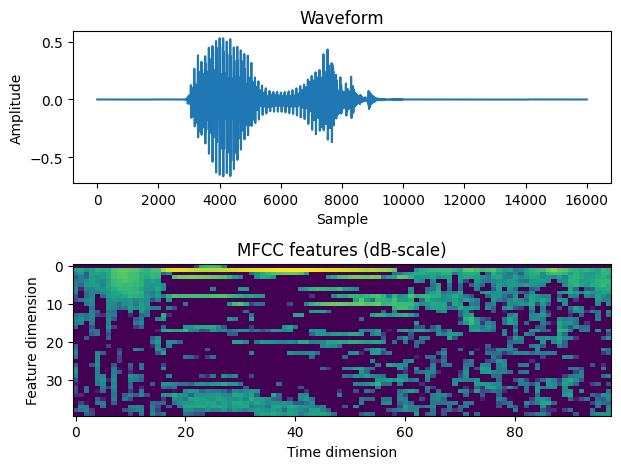

In [9]:
waveform = reduced_train_set[1][0] # Pick first waveform in train set
print("waveform: ",waveform)
print("Type, ", type(waveform), waveform.shape)
features = mfcc(waveform) # Compute MFCC

# Transform to dB scale and set minimum value to 0.1 for visualisation purposes.
features_dB = 10.0 * torch.log10(torch.maximum(torch.tensor(1e-1), features))

fig, axs = plt.subplots(2, 1)
axs[0].plot(waveform[0].numpy())
axs[0].set_title("Waveform")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[1].imshow(features_dB[0].numpy(), aspect="auto")
axs[1].set_title("MFCC features (dB-scale)")
axs[1].set_xlabel("Time dimension")
axs[1].set_ylabel("Feature dimension")

fig.tight_layout()
fig.show()


# Baseline

First: Train a KWT model on the reduced training dataset

Let's create the model

In [10]:
kwt_hparams = {"input_res": [40, 98], # Input size
               "patch_res": [40, 1], # Size of each patch [Frequency, Time]
               "num_classes": 35, # Number of keyword classes
               "mlp_dim": 256, # Dimension of transformer MLP
               "dim": 64, # Dimension of transformer output
               "heads": 1, # Number of attention heads
               "depth": 12, # Number of layers
               "dropout": 0.0, # Input droput
               "emb_dropout": 0.1, # Dropout between encoder layers
               "pre_norm": False} # Normalization before or after MLP

kwt = KWT(**kwt_hparams)

Let's define some data loaders and loss function and optimizer

In [11]:
train_loader = DataLoader(reduced_train_set, shuffle=True, batch_size=512, num_workers=2, pin_memory=True,
                          collate_fn=collate_fn)
validation_loader = DataLoader(validation_set, shuffle=False, batch_size=512, num_workers=2, pin_memory=True,
                         collate_fn=collate_fn)
test_loader = DataLoader(test_set, shuffle=False, batch_size=512, num_workers=2, pin_memory=True,
                         collate_fn=collate_fn)

criterion_baseline = nn.CrossEntropyLoss(label_smoothing=0.1)

lr = 0.001 # You can update this value to see if learning rate affects performance
weight_decay = 0.1 # You can update this value to see if weight decay affects performance
optimizer_baseline = torch.optim.AdamW(kwt.parameters(), lr=lr, weight_decay=weight_decay)

Training functions

In [12]:
def train_single_batch(net, features, labels, optimizer, criterion, device):
    features, labels = features.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    correct = outputs.argmax(1).eq(labels).sum()
    return loss.item(), correct.item()

@torch.no_grad()
def evaluate(net, criterion, dataloader, device):
    net.eval()
    correct = 0
    running_loss = 0.0

    for waveforms, labels in tqdm(dataloader, leave=False, total=len(dataloader), unit="batch"):
        features = mfcc(waveforms)
        features, labels = features.to(device), labels.to(device)

        outputs = net(features)
        correct += outputs.argmax(1).eq(labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss += loss.item()

    net.train()
    accuracy = correct / len(dataloader.dataset)
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

Trained for 40 epochs, <br>
For Batch size 64 it took approx 40 minutes <br>
For batch size 512 it took approx 40 minutes <br>

Let's train on 15 epochs ---

In [13]:
import torch
print(torch.cuda.is_available())
torch.cuda.empty_cache()
print(torch.version.cuda)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
12.1
0
NVIDIA GeForce GTX 1650


In [14]:
epochs = 15 # You can reduce this to save time, but will affect performance

# Learning rate scheduler with linear warmup
warmup_rate = 0.1 # percentage of epochs used to warmup learning rate
n_warmup = round(epochs*warmup_rate)
schedulers = {"warmup": WarmUpLR(optimizer_baseline,
                                 total_iters=len(train_loader) * n_warmup),
              "scheduler": CosineAnnealingLR(optimizer_baseline,
                                             len(train_loader) * max(1, epochs - n_warmup),
                                             eta_min=1e-8)}
# Send model to GPU if available
kwt = kwt.to(device)

# Placeholders
losses = {}
accuracies = {}
validation_losses = {}
validation_accuracies = {}

for epoch in (progress_bar := tqdm(range(epochs), unit="Epoch")):
    running_loss = 0.0
    running_correct = 0
    processed = 0

    for batch_index, data in tqdm(enumerate(train_loader), leave=False, position=1, total=len(train_loader), unit="batch"):
        waveforms, labels = data

        features = mfcc(waveforms)

        # Here we apply a data augmentation method called SpecAugment to improve generalization.
        # Very simply, we mask out some time and frequency bands,
        # making the training task more difficult as the model cannot
        # heavily rely on specific features for its prediction.
        features = spec_augment(features)

        loss, correct = train_single_batch(kwt, features, labels, optimizer_baseline, criterion_baseline, device)
        running_loss += loss
        running_correct += correct
        processed += features.size(0)

        progress_bar.set_description(f"Epoch loss: {running_loss/(batch_index+1):.2f} | Epoch accuracy: {running_correct/(processed)*100:.2f}% | Batch step: {batch_index + 1}/{len(train_loader)} - ")

        if schedulers["warmup"] is not None and epoch < n_warmup:
            schedulers["warmup"].step()

        elif schedulers["scheduler"] is not None:
            schedulers["scheduler"].step()

    losses[str(epoch)] = running_loss/len(train_loader)
    accuracies[str(epoch)] = running_correct/len(train_loader.dataset)

    # Validate model after each epoch
    validation_accuracy, validation_loss = evaluate(kwt, criterion_baseline, validation_loader, device)
    validation_losses[str(epoch)] = validation_loss
    validation_accuracies[str(epoch)] = validation_accuracy

    

  0%|          | 0/15 [00:00<?, ?Epoch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

Last train loss: 2.31, Last train accuracy: 42.44%


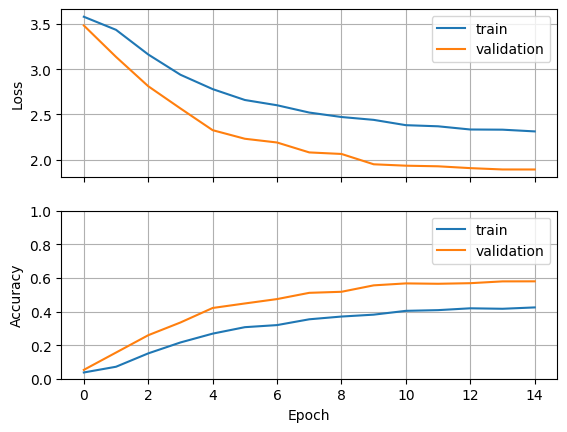

In [15]:
last_epoch = list(losses.keys())[-1]
print(f"Last train loss: {losses[last_epoch]:.2f}, Last train accuracy: {accuracies[last_epoch]*100:.2f}%")
plot_loss_accuracy(losses, accuracies, validation_losses, validation_accuracies, grid=True)

Checking Test Score:

In [16]:
test_acc, test_loss = evaluate(kwt, criterion_baseline, test_loader, device)
print(f" Test loss: {test_loss:.2f}, Test accuracy: {test_acc*100:.2f}%")

  0%|          | 0/22 [00:00<?, ?batch/s]

 Test loss: 1.92, Test accuracy: 55.93%


# Pretraining

Settings for Data2Vec

In [17]:
data2vec_hparams = {"model_embed_dim": 64,
           "ema_decay": 0.999,
           "ema_end_decay": 0.9999,
           "ema_anneal_end_step": 1000,
           "average_top_k_layers": 8,
           "normalize_targets": True}

mask_hparams = {"mask_prob": 0.65,
                "mask_length": 10,
                "attention_mask": None,
                "min_masks": 0}

Let's first create a Data2Vec model with a KWT model as the encoder

In [18]:
kwt_SSL = KWT(**kwt_hparams)
data2vec = Data2Vec(encoder=kwt_SSL,
                    **data2vec_hparams)

Generating mask during pretraining

In [19]:
mask_generator = AudioMaskingGenerator(**mask_hparams)

defining Epoch, dataloader, loss function (criterion) and optimizer

In [20]:
pretrain_loader = DataLoader(pretrain_set, shuffle=True, batch_size=512, num_workers=2, pin_memory=True, collate_fn=collate_fn)

criterion_data2vec = nn.MSELoss(reduction="none")

parameters_data2vec = data2vec.parameters()
optimizer_data2vec = torch.optim.Adam(parameters_data2vec,
                                      lr=0.0005,
                                      betas=(0.9, 0.98),
                                      eps=0.000001,
                                      weight_decay=0.01)

Training function for Data2Vec

In [21]:
def train_single_batch_data2vec(net, data, mask, optimizer, criterion, device):
    data = data.to(device)

    optimizer.zero_grad()
    predictions, targets = net(data, data, mask)
    scale = predictions.size(dim=-1)**0.5
    loss = criterion(predictions.float(), targets.float()).sum(dim=-1).sum().div(scale)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        target_var = compute_var(targets.float())
        prediction_var = compute_var(predictions.float())
    return loss.item(), target_var.item(), prediction_var.item()


@torch.no_grad()
def evaluate_data2vec(net, mask_generator, criterion, dataloader, device):
    net.eval()

    running_loss = 0.0
    running_target_var = 0.0
    running_prediction_var = 0.0

    for waveforms, labels in tqdm(dataloader):
        features = mfcc(waveforms)
        features, labels = features.to(device), labels.to(device)
        batch_size = features.size(dim=0)
        audio_length = features.size(dim=-1)

        mask = mask_generator(shape=(batch_size, audio_length)).to(device)
        mask = torch.cat([torch.zeros(batch_size, 1, device=mask.device), mask], dim=1).bool()

        predictions, targets = net(features, features, mask)
        scale = predictions.size(dim=-1)**0.5
        loss = criterion(predictions.float(), targets.float()).sum(dim=-1).sum().div(scale)
        target_var = compute_var(targets.float())
        prediction_var = compute_var(predictions.float())
        running_loss += loss.item()
        running_target_var += target_var.item()
        running_prediction_var += prediction_var.item()

    avg_loss = running_loss / len(dataloader.dataset)
    avg_target_var = running_target_var / len(dataloader)
    avg_prediction_var = running_prediction_var / len(dataloader)
    return avg_loss, avg_target_var, avg_prediction_var


Pretrain the Data2Vec model for 80 epochs

In [21]:
pretrain_epochs = 80

# Placeholders
losses_data2vec = {}
target_vars = {}
prediction_vars = {}
validation_losses_data2vec = {}
validation_target_vars = {}
validation_prediction_vars = {}
processed = 0

# Learning rate scheduler
scheduler_data2vec = OneCycleLR(optimizer_data2vec,
                       max_lr=0.0005, # change if desired
                       epochs=pretrain_epochs,
                       steps_per_epoch=len(pretrain_loader),
                       anneal_strategy="cos")

data2vec = data2vec.to(device)
data2vec.train()
for epoch in (progress_bar := tqdm(range(pretrain_epochs), unit="Epoch")):
    running_loss = 0.0
    running_target_var = 0.
    running_prediction_var = 0.
    for batch_index, data, in tqdm(enumerate(pretrain_loader), total=len(pretrain_loader), unit="Batch"):
        waveforms, _ = data

        features = mfcc(waveforms)

        batch_size = features.size(dim=0)
        audio_length = features.size(dim=-1)


        mask = mask_generator(shape=(batch_size, audio_length)).to(device)
        mask = torch.cat([torch.zeros(batch_size, 1, device=mask.device), mask], dim=1).bool()

        loss, target_var, prediction_var = train_single_batch_data2vec(data2vec, features, mask, optimizer_data2vec, criterion_data2vec, device)
        data2vec.ema_step()

        running_loss += loss
        running_target_var += target_var
        running_prediction_var += prediction_var
        processed += batch_size

        progress_bar.set_description(f"Epoch loss: {running_loss/(batch_index+1):.2f} | Prediction variance: {running_prediction_var/(batch_index+1):.2f} | Target variance: {running_target_var/(batch_index+1):.2f} | Batch step: {batch_index + 1}/{len(pretrain_loader)} - ")

        scheduler_data2vec.step()

    losses_data2vec[str(epoch)] = running_loss/len(pretrain_loader)
    target_vars[str(epoch)] = running_target_var/len(pretrain_loader)
    prediction_vars[str(epoch)] = running_prediction_var/len(pretrain_loader)

    validation_loss, validation_target_var, validation_prediction_var = evaluate_data2vec(net=data2vec, mask_generator=mask_generator,
                                                                                          criterion=criterion_data2vec,
                                                                                          dataloader=validation_loader, device=device)

    validation_losses_data2vec[str(epoch)] = validation_loss
    validation_target_vars[str(epoch)] = validation_target_var
    validation_prediction_vars[str(epoch)] = validation_prediction_var

  0%|          | 0/80 [00:00<?, ?Epoch/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?Batch/s]

  0%|          | 0/20 [00:00<?, ?it/s]

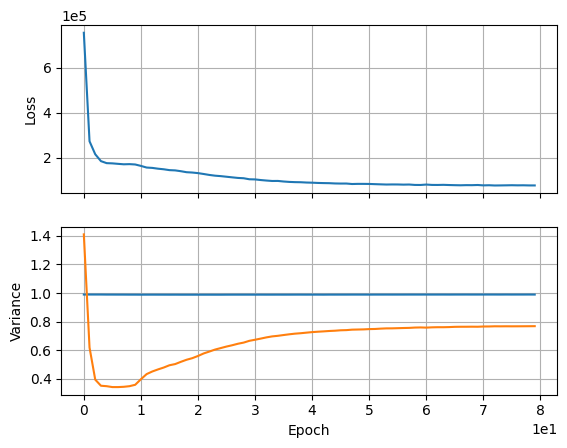

In [22]:
plot_loss_and_variance(losses_data2vec, target_vars, prediction_vars, grid=True)

In [23]:
test_loss, test_target_var, test_prediction_var = evaluate_data2vec(data2vec, mask_generator, criterion_data2vec, test_loader, device)

  0%|          | 0/22 [00:00<?, ?it/s]

In [24]:
print(f"Test loss: {test_loss:.2f}, Test target variance: {test_target_var:.2f}, Test prediction variance: {test_prediction_var:.2f}")

Test loss: 146.38, Test target variance: 0.99, Test prediction variance: 0.77


# Fine-tuning

In [22]:
use_checkpoint = True # set use_checkpoint=True to load a pretrained model, otherwise set it to False.

if use_checkpoint:
  kwt_pretrained = KWT(**kwt_hparams)
  kwt_pretrained = load_pretrained_checkpoint(kwt_pretrained)
else:
  kwt_pretrained = copy.deepcopy(data2vec.encoder.cpu())

kwt_pretrained = kwt_pretrained.to(device)

Checkpoint already available skipping download...
Loading checkpoint weights...
Checkpoint loaded.


/tmp/ipykernel_4561/3760449604.py:583: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./pretrained_encoder.pth", map_location=torch.device('cpu'))


In [23]:
epochs = 15

train_loader = DataLoader(reduced_train_set, shuffle=True, batch_size=512, num_workers=2, pin_memory=True,
                          collate_fn=collate_fn)
validation_loader = DataLoader(validation_set, shuffle=False, batch_size=512, num_workers=2, pin_memory=True,
                         collate_fn=collate_fn)
test_loader = DataLoader(test_set, shuffle=False, batch_size=512, num_workers=2, pin_memory=True,
                         collate_fn=collate_fn)

optimizer_finetune = torch.optim.AdamW(kwt_pretrained.parameters(), lr =0.001, weight_decay=0.1)

warmup_rate = 0.10
n_warmup = round(epochs*warmup_rate)
schedulers = {"warmup": WarmUpLR(optimizer_finetune,
                                 total_iters=len(train_loader) * n_warmup),
              "scheduler": CosineAnnealingLR(optimizer_finetune,
                                             len(train_loader) * max(1, epochs - n_warmup),
                                             eta_min=1e-8)}

criterion_finetune = nn.CrossEntropyLoss(label_smoothing=0.1)

In [24]:
losses_finetune = {}
accuracies_finetune = {}

validation_losses_finetune = {}
validation_accuracies_finetune = {}

kwt_pretrained.train()
for epoch in (progress_bar := tqdm(range(epochs), unit="Epoch")):
    running_loss = 0.0
    running_correct = 0
    processed = 0
    for batch_index, data in tqdm(enumerate(train_loader), leave=False, position=1, total=len(train_loader), unit="batch"):
        waveforms, labels = data

        features = mfcc(waveforms)

        loss, correct = train_single_batch(kwt_pretrained, features, labels, optimizer_finetune, criterion_finetune, device)
        running_loss += loss
        running_correct += correct
        processed += features.size(0)

        progress_bar.set_description(f"Epoch loss: {running_loss/(batch_index+1):.2f} | Epoch accuracy: {running_correct/(processed)*100:.2f}% | Batch step: {batch_index + 1}/{len(train_loader)} - ")

        if schedulers["warmup"] is not None and epoch < n_warmup:
            schedulers["warmup"].step()

        elif schedulers["scheduler"] is not None:
            schedulers["scheduler"].step()

    losses_finetune[str(epoch)] = running_loss/len(train_loader)
    accuracies_finetune[str(epoch)] = running_correct/len(train_loader.dataset)

    validation_accuracy, validation_loss = evaluate(kwt_pretrained, criterion_baseline, validation_loader, device)
    validation_losses_finetune[str(epoch)] = validation_loss
    validation_accuracies_finetune[str(epoch)] = validation_accuracy

  0%|          | 0/15 [00:00<?, ?Epoch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/34 [00:00<?, ?batch/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

Last finetune train loss: 1.19, Last finetune train accuracy: 82.82%


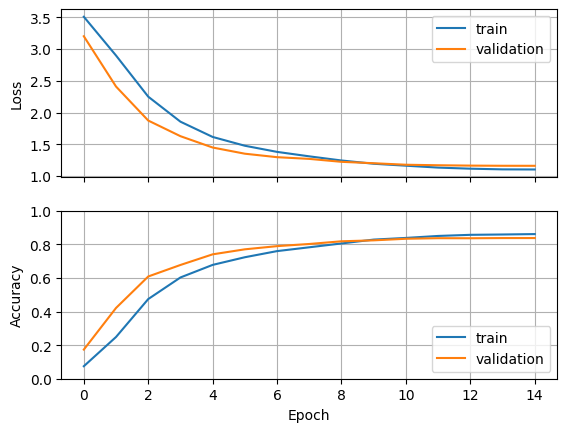

In [25]:
print(f"Last finetune train loss: {losses_finetune[sorted(losses_finetune.keys())[-1]]:.2f}, Last finetune train accuracy: {accuracies_finetune[sorted(accuracies_finetune.keys())[-1]]*100:.2f}%")
plot_loss_accuracy(losses_finetune, accuracies_finetune, validation_losses_finetune, validation_accuracies_finetune, grid=True)

In [26]:
test_acc, test_loss = evaluate(kwt_pretrained, criterion_finetune, test_loader, device)
print(f" Test loss: {test_loss:.2f}, Test accuracy: {test_acc*100:.2f}%")

  0%|          | 0/22 [00:00<?, ?batch/s]

 Test loss: 1.21, Test accuracy: 81.84%


# Training Comparison

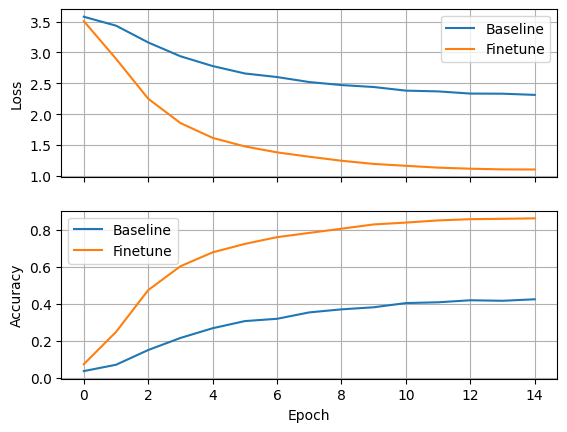

In [27]:
fig, axs = plt.subplots(2, 1, sharex=True)

baseline_epochs_list = list(losses.keys())
baseline_epochs_list = [int(number) for number in baseline_epochs_list]
finetune_epochs_list = list(losses_finetune.keys())
finetune_epochs_list = [int(number) for number in finetune_epochs_list]

losses_baseline_list = list(losses.values())
losses_finetune_list = list(losses_finetune.values())
accuracies_baseline_list = list(accuracies.values())
accuracies_finetune_list = list(accuracies_finetune.values())

axs[0].plot(baseline_epochs_list, losses_baseline_list, label="Baseline")
axs[0].plot(finetune_epochs_list, losses_finetune_list, label="Finetune")
axs[1].plot(baseline_epochs_list, accuracies_baseline_list, label="Baseline")
axs[1].plot(finetune_epochs_list, accuracies_finetune_list, label="Finetune")

axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

axs[0].grid()
axs[1].grid()

axs[0].legend()
axs[1].legend()

plt.show()

## Validation Comparison

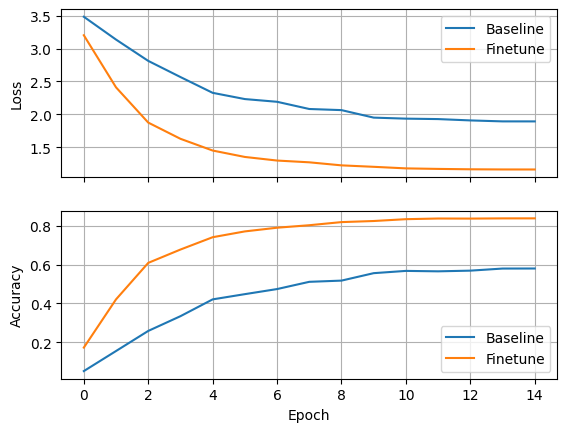

In [28]:
fig, axs = plt.subplots(2, 1, sharex=True)

validation_baseline_epochs_list = list(validation_losses.keys())
validation_baseline_epochs_list = [int(number) for number in validation_baseline_epochs_list]
validation_finetune_epochs_list = list(validation_losses_finetune.keys())
validation_finetune_epochs_list = [int(number) for number in validation_finetune_epochs_list]

validation_losses_baseline_list = list(validation_losses.values())
validation_losses_finetune_list = list(validation_losses_finetune.values())
validation_accuracies_baseline_list = list(validation_accuracies.values())
validation_accuracies_finetune_list = list(validation_accuracies_finetune.values())

axs[0].plot(validation_baseline_epochs_list, validation_losses_baseline_list, label="Baseline")
axs[0].plot(validation_finetune_epochs_list, validation_losses_finetune_list, label="Finetune")
axs[1].plot(validation_baseline_epochs_list, validation_accuracies_baseline_list, label="Baseline")
axs[1].plot(validation_finetune_epochs_list, validation_accuracies_finetune_list, label="Finetune")

axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

axs[0].grid()
axs[1].grid()

axs[0].legend()
axs[1].legend()

plt.show()